In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [3]:
HOUSING_DATA_PATH = "data/homework02/housing.csv"
try:
    os.makedirs("data/homework02")
except OSError:
    pass

In [4]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -P data/homework02

--2023-09-21 18:49:09--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘data/homework02/housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.05s   

2023-09-21 18:49:09 (28.6 MB/s) - ‘data/homework02/housing.csv’ saved [1423529/1423529]



## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

### EDA

* Load the data.
* Look at the `median_house_value` variable. Does it have a long tail? 

<Axes: xlabel='median_house_value', ylabel='Count'>

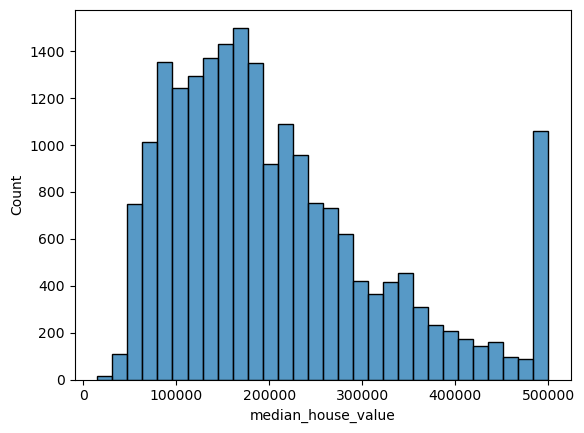

In [4]:
df = pd.read_csv(HOUSING_DATA_PATH)
sns.histplot(df.median_house_value, bins=30)

### Preparing the dataset 

For this homework, we only want to use a subset of data. 

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Next, use only the following columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`

In [5]:
def prepare_dataset(df):

    df_filtered = df[df.ocean_proximity.isin(['<1H OCEAN','INLAND'])]   
    base = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
    target_median_house_value = df_filtered['median_house_value']
    df_filtered = df_filtered[base]
    return df_filtered, target_median_house_value

### Question 1

There's one feature with missing values. What is it?

* `total_rooms`
* `total_bedrooms`
* `population`
* `households`


In [6]:
df_filtered, target_median_house_value = prepare_dataset(df)


In [7]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Question 2

What's the median (50% percentile) for variable `'population'`?

- 995
- 1095
- 1195
- 1295


In [8]:
df_filtered.population.median()

1195.0

<Axes: xlabel='population', ylabel='Count'>

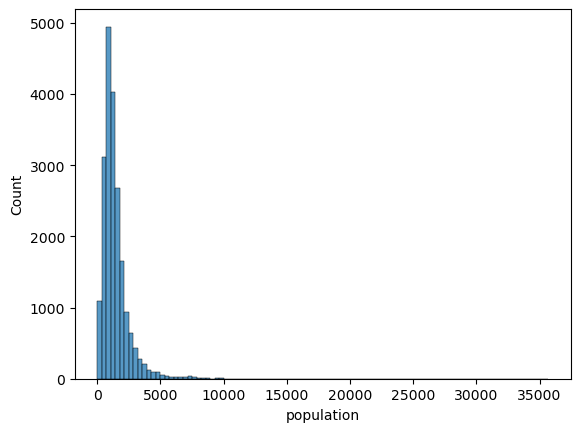

In [9]:

sns.histplot(df.population, bins=100)

### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Apply the log transformation to the `median_house_value` variable using the `np.log1p()` function.


In [10]:
df_filtered = df_filtered.reset_index(drop=True)
df_filtered["median_house_value"] = np.log1p(df_filtered["median_house_value"])

In [11]:
np.random.seed(42)
shuffled_index = df_filtered.index.values
np.random.shuffle(shuffled_index)

In [12]:
n = df_filtered.shape[0]
n_train = int(n * 0.6)
n_val = int(n * 0.2)
n_test = n - n_train - n_val
n, n_train, n_val, n_test

(15687, 9412, 3137, 3138)

In [13]:
df_train = df_filtered.iloc[shuffled_index[:n_train]].reset_index(drop=True)
df_val = df_filtered.iloc[shuffled_index[n_train:n_train + n_val]].reset_index(drop=True)
df_test = df_filtered.iloc[shuffled_index[n_train + n_val:]].reset_index(drop=True)
df_train.shape, df_val.shape, df_test.shape

((9412, 9), (3137, 9), (3138, 9))

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?


In [14]:
df_tzero = df_train.copy()
df_tmean = df_train.copy()

df_tzero = df_tzero.fillna(0)
df_tmean["total_bedrooms"] = df_tmean.total_bedrooms.fillna(df_tzero.total_bedrooms.mean())

In [26]:
df_tzero_val = df_val.copy()
df_tmean_val = df_val.copy()

df_tzero_val = df_tzero_val.fillna(0)
df_tmean_val["total_bedrooms"] = df_tmean_val.total_bedrooms.fillna(df_tzero.total_bedrooms.mean())

In [15]:
def train_linear_regression(df):
    target_median_house_value = df.median_house_value
    df = df.copy()
    del df["median_house_value"]
    

    X = df.values
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX_inv = np.linalg.inv(X.T.dot(X))
    w = (XTX_inv).dot(X.T).dot(target_median_house_value)
    return w[0], w[1:]
    

In [16]:
def evaluate(df, w0, w):
    df = df.copy()
    if "median_house_value" in df:
        del df["median_house_value"]
    
    return w0 + df.values.dot(w) 

In [17]:
def RMSE(prediction, target):
    """Root Mean Square Error"""
    return np.sqrt(((prediction - target)**2).mean())

In [18]:
w_tzero = train_linear_regression(df_tzero)
target = df_val["median_house_value"]


In [29]:
prediction_tzero = evaluate(df_tzero_val, *w_tzero)
round(RMSE(prediction=prediction_tzero, target=target.values), 2)

0.34

In [30]:
w_tmean = train_linear_regression(df_tmean)
prediction_tmean = evaluate(df_tmean_val, *w_tmean)
round(RMSE(prediction=prediction_tmean, target=target.values), 2)

0.34

* Which option gives better RMSE?

Options:

- With 0
- With mean
- [x] Both are equally good


### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [31]:
def train_linear_regression_regularized(df, r=0):
    target_median_house_value = df.median_house_value
    df = df.copy()
    del df["median_house_value"]
    

    X = df.values
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = (XTX_inv).dot(X.T).dot(target_median_house_value)
    return w[0], w[1:]
    

In [59]:
def train_and_eval(r, df_train, df_val, rounding=None):
    w_tzero = train_linear_regression_regularized(df_train, r=r)
    target = df_val["median_house_value"]
    prediction_tzero = evaluate(df_val, *w_tzero)
    rmse = RMSE(prediction=prediction_tzero, target=target.values)
    
    if rounding is None:
        return rmse
    
    return round(rmse, rounding)

In [54]:
import sys
# Regularization candidates
r_candidates = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
arg_min = None
min_rmse = sys.maxsize
for r in r_candidates:
    rmse = train_and_eval(r, df_train, df_tzero_val, rounding=2)
    # print(r, rmse)
    if rmse < min_rmse:
        min_rmse = rmse
        arg_min = r

print("Minimal R:", arg_min, "RMSE:", min_rmse)


Minimal R: 0 RMSE: 0.34


If there are multiple options, select the smallest `r`.

Options:

- [x] 0
- 0.000001
- 0.001
- 0.0001

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 0.5
- 0.05
- 0.005
- 0.0005

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.


In [61]:
def split_dataset(df, seed):
    np.random.seed(seed)

    shuffled_index = df.index.values
    np.random.shuffle(shuffled_index)

    n = df.shape[0]
    n_train = int(n * 0.6)
    n_val = int(n * 0.2)

    df_train = df.iloc[shuffled_index[:n_train]].reset_index(drop=True)
    df_val = df.iloc[shuffled_index[n_train:n_train + n_val]].reset_index(drop=True)
    df_test = df.iloc[shuffled_index[n_train + n_val:]].reset_index(drop=True)
    return df_train, df_val, df_test

In [62]:
def test_seeds(seed, rounding=None):
    df_train, df_val, df_test = split_dataset(df_filtered, seed)
    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)
    df_test = df_test.fillna(0)

    return train_and_eval(
        r=0, rounding=rounding, df_train=df_train, df_val=df_val
    )


In [65]:
seed_range = np.arange(0, 10)
rmses = np.array([test_seeds(s, rounding=3) for s in seed_range])
rmses_std = round(np.std(rmses), 3)
rmses_std

0.005

What's the value of std?

- 0.5
- 0.05
- [x] 0.005
- 0.0005

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 0.13
- 0.23
- 0.33
- 0.43



In [101]:
def train_and_test(df):
    df_train, df_val, df_test = split_dataset(df, seed=9)
    df_full_train = pd.concat([df_train, df_val])
    df_full_train = df_full_train.reset_index(drop=True)

    df_full_train = df_full_train.fillna(0)
    df_test = df_test.fillna(0)
    return train_and_eval(r=0.001, df_train=df_full_train, df_val=df_test, rounding=2)

In [105]:
train_and_test(df_filtered)

0.33

* What's the RMSE on the test dataset?

Options:

- 0.13
- 0.23
-  [x]0.33
- 0.43